## Going through all of the Cygnus X-1 observations to see which are in the hard state by comparing the cross spectrum of each with the observations we know to be in the hard state (01250101,01002901)

Ive edited the master GTI code as it had a bug related to indexing that is unique to the way python works. Since python starts at 0 i changed the idex to be the count-1 as this will be the last one if 0 is the first. I tested that I get the same set of GTIs for the old cyg may and june obs and rxj and found that it gets stuck in a loop with herx-1 because for some reason the gtis are all the same? so if the last gti is below tstop it just repeats the last loop forever. Ive added catches for this now and made master gtis for all cyg files. now to make cross spectra..

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/c2032014/py_files')
import master_GTI as mg
import importlib
importlib.reload(mg)

<module 'master_GTI' from '/home/c2032014/py_files/master_GTI.py'>

/home/c2032014/.local/lib/python3.10/site-packages/stingray/fourier.py:1139: RuntimeWarning: invalid value encountered in sqrt
  dRe = dIm = dG = np.sqrt(power_over_2n * (seg_power - frac))
/home/c2032014/.local/lib/python3.10/site-packages/stingray/fourier.py:1141: RuntimeWarning: invalid value encountered in sqrt
  dphi = np.sqrt(
/home/c2032014/.local/lib/python3.10/site-packages/stingray/crossspectrum.py:2912: UserWarning: Some error bars in the Averaged Crossspectrum are invalid.Defaulting to sqrt(2 / M) in Leahy norm, rescaled to the appropriate norm.
  warnings.warn(
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/c2032014/.local/lib/python3.10/site-packages/stingray/fourier.py:1139: RuntimeWarning: invalid value encountered in sqrt
  dRe = dIm = dG = np.sqrt(power_over_2n * (seg_power - frac))
/home/c2032014/.local/lib/python3.10/site-packages/stingra

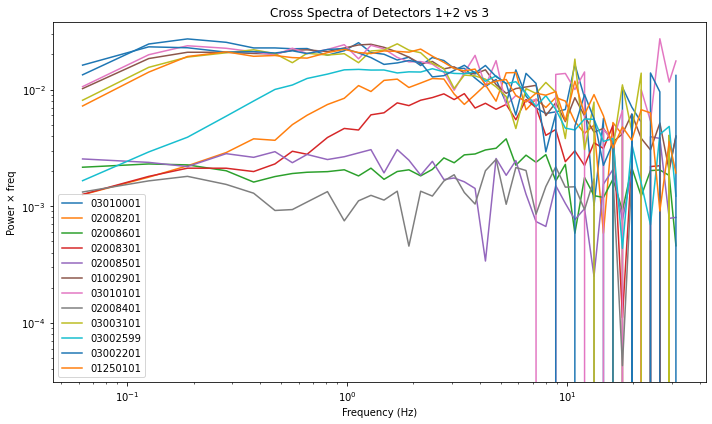

In [77]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from stingray import Lightcurve, AveragedCrossspectrum

Pmin = 51
Pmax = 200
base_path = '/home/c2032014/cygx1_paper/cyg_data_all'

# Set up one figure for all cross spectra
plt.figure(figsize=(10, 6))

# Loop through all subdirectories with 7-digit names
for folder_name in os.listdir(base_path):
    if not folder_name.isdigit() or len(folder_name) != 8:
        continue  # Skip non-8-digit directories

    folder_path = os.path.join(base_path, folder_name)
    #print(folder_path)
    #print(f"Processing folder: {folder_name}")

    try:
        # Load and filter data for Detectors 1 and 2
        times = []
        for det in [1, 2]:
            pattern = os.path.join(folder_path, f"ixpe{folder_name}_det{det}_evt2_v0*_src.fits")
            #print('pattern', pattern)
            fits_file = glob.glob(pattern)[0]
            with fits.open(fits_file) as hdu:
                data = hdu[1].data
                data = data[(Pmin <= data['PI']) & (data['PI'] <= Pmax)]
                times.append(data['TIME'])

        det_12_time = np.concatenate(times)

        # Detector 3
        pattern = os.path.join(folder_path, f"ixpe{folder_name}_det3_evt2_v0*_src.fits")
        fits_file = glob.glob(pattern)[0]
        with fits.open(fits_file) as hdu:
            data = hdu[1].data
            data = data[(Pmin <= data['PI']) & (data['PI'] <= Pmax)]
            det3_time = data['TIME']

        # GTI file
        gti_pattern = os.path.join(folder_path, f"GTI_ixpe{folder_name}_evt2_v0*.txt")
        gti_file = glob.glob(gti_pattern)[0]
        gti_data = np.loadtxt(gti_file)

        # Lightcurves
        lc_12 = Lightcurve.make_lightcurve(det_12_time, dt=1/64, gti=list(gti_data))
        lc_12.apply_gtis()
        #print(lc_12)
        lc_3 = Lightcurve.make_lightcurve(det3_time, dt=1/64, gti=list(gti_data))
        lc_3.apply_gtis()

        # Cross Spectrum
        cs = AveragedCrossspectrum(lc_12, lc_3, 16)
        cs_rebin=cs.rebin_log(0.1)

        # Plot on shared figure
        plt.plot(cs_rebin.freq, cs_rebin.power * cs_rebin.freq, label=f'{folder_name}')
        #plt.errorbar(cs_rebin.freq, cs_rebin.power * cs_rebin.freq, yerr=cs_rebin.power_err * cs_rebin.freq, fmt='o', alpha=0.5)

    except Exception as e:
        print(f"Error processing {folder_name}: {e}")

# Finalize shared plot
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power × freq')
plt.title('Cross Spectra of Detectors 1+2 vs 3')
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from astropy.io import fits
from stingray import Lightcurve, AveragedCrossspectrum

# ------------------------
# Settings
# ------------------------
Pmin = 51
Pmax = 200
base_path = '/home/c2032014/cygx1_paper/cyg_data_all'

hard_state = ['01002901','01250101','03002201','03003101','03010001','03010101']

mid_state=['03002599','02008301','02008201']

# Dictionary to store results
cross_spectra_data_rebin = {}

# ------------------------
# Loop over ObsIDs
# ------------------------
for folder_name in os.listdir(base_path):
    if not folder_name.isdigit() or len(folder_name) != 8:
        continue  # Skip non-8-digit directories

    folder_path = os.path.join(base_path, folder_name)

    try:
        # Load and filter data for Detectors 1 and 2
        times = []
        for det in [1, 2]:
            pattern = os.path.join(folder_path, f"ixpe{folder_name}_det{det}_evt2_v0*_src.fits")
            fits_file = glob.glob(pattern)[0]
            with fits.open(fits_file) as hdu:
                data = hdu[1].data
                data = data[(Pmin <= data['PI']) & (data['PI'] <= Pmax)]
                times.append(data['TIME'])

        det_12_time = np.concatenate(times)

        # Detector 3
        pattern = os.path.join(folder_path, f"ixpe{folder_name}_det3_evt2_v0*_src.fits")
        fits_file = glob.glob(pattern)[0]
        with fits.open(fits_file) as hdu:
            data = hdu[1].data
            data = data[(Pmin <= data['PI']) & (data['PI'] <= Pmax)]
            det3_time = data['TIME']

        # GTI file
        gti_pattern = os.path.join(folder_path, f"GTI_ixpe{folder_name}_evt2_v0*.txt")
        gti_file = glob.glob(gti_pattern)[0]
        gti_data = np.loadtxt(gti_file)

        # Lightcurves
        lc_12 = Lightcurve.make_lightcurve(det_12_time, dt=1/64, gti=list(gti_data))
        lc_12.apply_gtis()
        lc_3 = Lightcurve.make_lightcurve(det3_time, dt=1/64, gti=list(gti_data))
        lc_3.apply_gtis()

        # Cross Spectrum
        cs = AveragedCrossspectrum(lc_12, lc_3, 16,norm='frac')
        cs_rebin = cs.rebin_log(0.3)
        #cs_rebin=cs
    #cs_rebin=cs
        # Store (freq, power*freq, error) for later plotting
        freq = cs_rebin.freq
        power=cs_rebin.power 
        power_err = cs_rebin.power_err
        
        
        rebin_factor = 0.3  # Same as used in rebin_log
        # ---- Correct computation of log-rebin bin widths ----
        f = freq
        factor = 1 + rebin_factor

        # geometric edges
        edges = np.zeros(len(f) + 1)
        edges[1:-1] = np.sqrt(f[:-1] * f[1:])
        edges[0] = f[0] / np.sqrt(factor)
        edges[-1] = f[-1] * np.sqrt(factor)

        # true bin widths
        df = edges[1:] - edges[:-1]
        freq_err = df / 2     # half-widths for xerr

        #freq_diff=np.array([cs_rebin.freq[i+1]-cs_rebin.freq[i] for i in range(len(cs_rebin.freq))])/2

        #freq_err= cs_rebin.freq_err
        cross_spectra_data_rebin[folder_name] = (freq, power, power_err)

    except Exception as e:
        print(f"Error processing {folder_name}: {e}")



/home/c2032014/.local/lib/python3.10/site-packages/stingray/fourier.py:1139: RuntimeWarning: invalid value encountered in sqrt
  dRe = dIm = dG = np.sqrt(power_over_2n * (seg_power - frac))
/home/c2032014/.local/lib/python3.10/site-packages/stingray/fourier.py:1141: RuntimeWarning: invalid value encountered in sqrt
  dphi = np.sqrt(
/home/c2032014/.local/lib/python3.10/site-packages/stingray/crossspectrum.py:2912: UserWarning: Some error bars in the Averaged Crossspectrum are invalid.Defaulting to sqrt(2 / M) in Leahy norm, rescaled to the appropriate norm.
  warnings.warn(
/home/c2032014/.local/lib/python3.10/site-packages/stingray/fourier.py:1139: RuntimeWarning: invalid value encountered in sqrt
  dRe = dIm = dG = np.sqrt(power_over_2n * (seg_power - frac))
/home/c2032014/.local/lib/python3.10/site-packages/stingray/fourier.py:1141: RuntimeWarning: invalid value encountered in sqrt
  dphi = np.sqrt(
/home/c2032014/.local/lib/python3.10/site-packages/stingray/crossspectrum.py:2912: U

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/c2032014/.local/lib/python3.10/site-packages/numpy/ma/core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/c2032014/.local/lib/python3.10/site-packages/numpy/ma/core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/c2032014/.local/lib/python3.10/site-packages/numpy/ma/core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary par

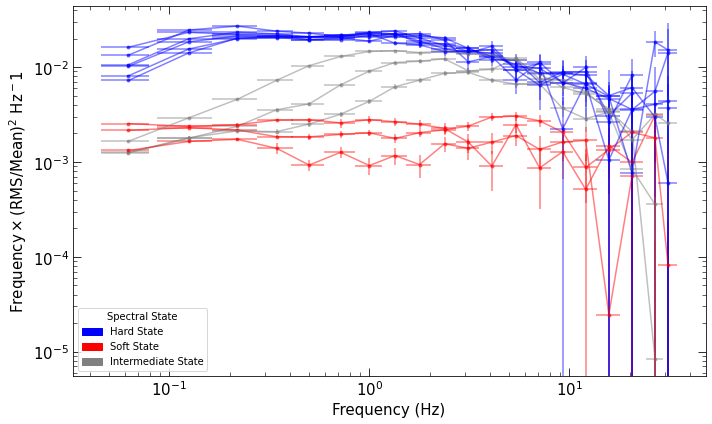

In [27]:
plt.figure(figsize=(10, 6))

for obsid, (freq, power, power_err) in cross_spectra_data_rebin.items():
    if obsid in hard_state:

        color = 'blue'
    elif obsid in mid_state:
        color = 'grey'
    else:
        color = 'red'
  
    #plt.plot(freq, power*freq, label=obsid, color=color)
    plt.errorbar(freq, power*freq,xerr=freq_err, yerr=power_err*freq, fmt='o', color=color, alpha=0.5, markersize=3,ls='-')

# Legend for states
state_legend = [
    Patch(color='blue', label='Hard State'),

    Patch(color='red', label='Soft State'),
    Patch(color='grey', label='Intermediate State')
]

plt.legend(handles=state_legend, loc='lower left', title='Spectral State')

plt.tick_params(axis='both', which='major', labelsize=15 ,top=True, right=True,direction='in',length=8 )
plt.tick_params(axis='both', which='minor', labelsize=12, top=True, right=True, direction='in',length=4)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)', size=15)
plt.ylabel(r'$ \rm Frequency \times (RMS/Mean)^2 \ \rm Hz^-1$', size=15)
plt.tight_layout()
plt.savefig('cross_spectra_states.pdf', dpi=1000)
plt.show()
